# Mean Forecast + Safety Stock

This notebook shows a clear workflow for using the mean forecast with safety stock.
It first optimizes safety stock without aggregation, then repeats the process with an aggregation window.


## Setup


In [1]:
import pandas as pd

from replenishment import (
    build_point_forecast_article_configs_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    evaluate_aggregation_and_service_level_factor_costs,
    evaluate_service_level_factor_costs,
    generate_standard_simulation_rows,
    optimize_aggregation_and_service_level_factors,
    optimize_service_level_factors,
    optimize_point_forecast_policy_and_simulate_actuals,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    split_standard_simulation_rows,
    simulate_replenishment_with_aggregation,
    standard_simulation_rows_from_dataframe,
    standard_simulation_rows_to_dataframe,
)


## Generate Sample Data


In [2]:
rows = generate_standard_simulation_rows(
    n_unique_ids=3,
    periods=120,
    history_mean=18,
    history_std=4,
    forecast_mean=16,
    forecast_std=3,
    seed=7,
    lead_time=5,
)
df = standard_simulation_rows_to_dataframe(rows, library="pandas")

# Overwrite current stock to simulate a known starting inventory position.
df["current_stock"] = 25

# Drop is_forecast so the cutoff defines the backtest/evaluation split.
df = df.drop(columns=["is_forecast"])

cutoff_period = 90
cutoff = sorted(df["ds"].unique())[cutoff_period - 1]
rows = standard_simulation_rows_from_dataframe(df, cutoff=cutoff)


## Split Backtest vs Forecast


In [3]:
backtest_rows, forecast_rows = split_standard_simulation_rows(rows)

backtest_actuals = {}
for row in backtest_rows:
    backtest_actuals.setdefault(row.unique_id, []).append(row)
for unique_id, series in backtest_actuals.items():
    series.sort(key=lambda r: r.ds)
    backtest_actuals[unique_id] = [int(r.actuals) for r in series]


## Step 1: Optimize Safety Stock (No Aggregation)


In [4]:
point_configs = build_point_forecast_article_configs_from_standard_rows(
    backtest_rows,
    service_level_factor=0.9,
)

sigma_costs = evaluate_service_level_factor_costs(
    point_configs,
    candidate_factors=[0.8, 0.9, 0.95, 1.0],
)
sigma_cost_rows = [
    {"unique_id": uid, "service_level_factor": factor, "total_cost": cost}
    for uid, factors in sigma_costs.items()
    for factor, cost in factors.items()
]
sigma_cost_df = pd.DataFrame(sigma_cost_rows)
sigma_cost_df


,unique_id,service_level_factor,total_cost
0,A,0.80,11155.5
1,A,0.90,12800.5
2,A,0.95,13770.0
3,A,1.00,14447.0
4,B,0.80,14442.0
5,B,0.90,16755.0
6,B,0.95,18029.0
7,B,1.00,19129.5
8,C,0.80,12366.5
9,C,0.90,14175.0


In [5]:
optimized, mean_forecast_simulations, mean_decision_rows = (
    optimize_point_forecast_policy_and_simulate_actuals(
        backtest_rows,
        forecast_rows,
        candidate_factors=[0.8, 0.9, 0.95, 1.0],
    )
)
best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in optimized.items()
}

mean_decision_df = replenishment_decision_rows_to_dataframe(
    mean_decision_rows,
    library="pandas",
)
mean_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,15,18,18,0,25,7,25,7,7,15,0,0,0.8,1,None
1,A,2031-06-23,24,16,16,0,7,0,7,0,0,39,9,9,0.8,1,None
2,A,2031-07-23,13,16,16,0,0,0,0,0,0,52,25,16,0.8,1,None
3,A,2031-08-22,19,21,21,0,0,0,0,0,0,71,46,21,0.8,1,None
4,A,2031-09-21,15,19,19,0,0,0,0,0,0,86,65,19,0.8,1,None


### Plot (No Aggregation)


0      0
1      9
2     16
3     21
4     19
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
Name: missed_sales, dtype: int64


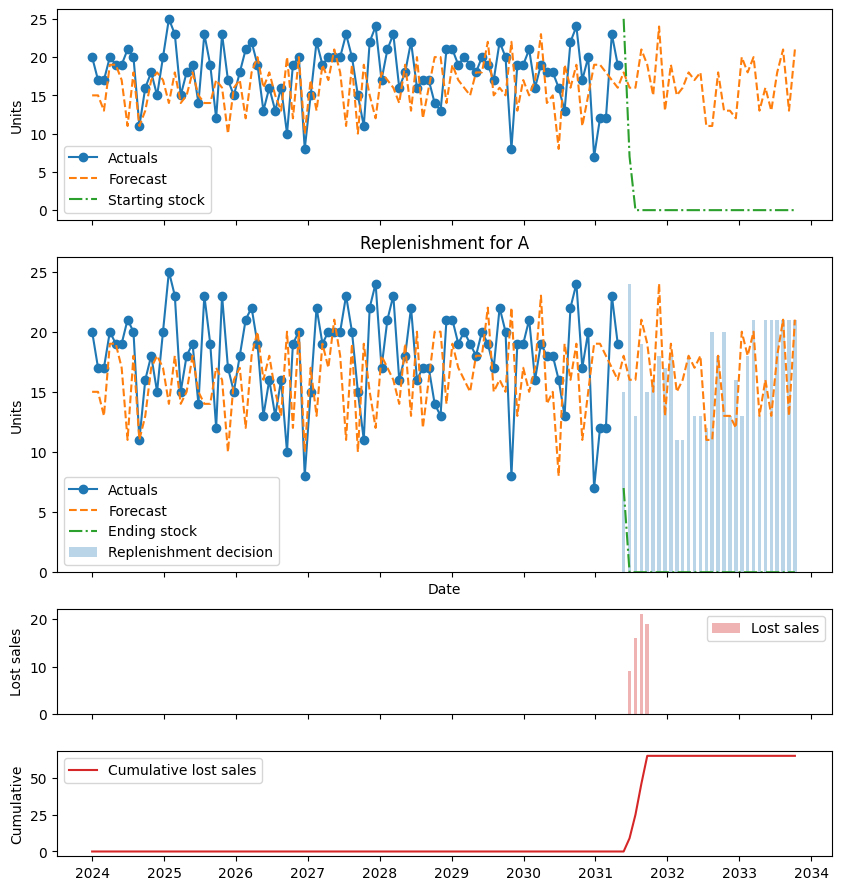

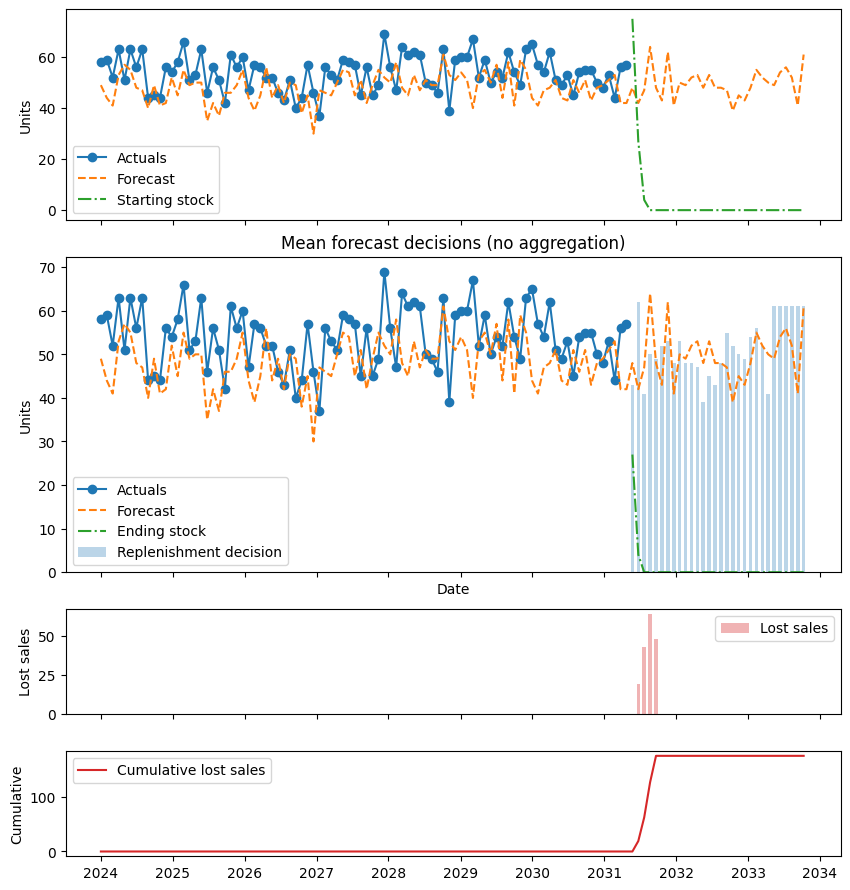

In [6]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, mean_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    mean_decision_df,
    aggregate=True,
    title="Mean forecast decisions (no aggregation)",
)


## Step 2: Optimize Aggregation Window + Safety Stock


In [7]:
agg_sigma_costs = evaluate_aggregation_and_service_level_factor_costs(
    point_configs,
    candidate_windows=[1, 2, 3, 4],
    candidate_factors=[0.8, 0.9, 0.95, 1.0],
)
agg_sigma_cost_rows = [
    {
        "unique_id": uid,
        "window": window,
        "service_level_factor": factor,
        "total_cost": cost,
    }
    for uid, window_costs in agg_sigma_costs.items()
    for window, factors in window_costs.items()
    for factor, cost in factors.items()
]
agg_sigma_cost_df = pd.DataFrame(agg_sigma_cost_rows)
agg_sigma_cost_df.head()


,unique_id,window,service_level_factor,total_cost
0,A,1,0.80,11155.5
1,A,1,0.90,12800.5
2,A,1,0.95,13770.0
3,A,1,1.00,14447.0
4,A,2,0.80,3516.5


In [8]:
agg_sigma_result = optimize_aggregation_and_service_level_factors(
    point_configs,
    candidate_windows=[1, 2, 3, 4],
    candidate_factors=[0.8, 0.9, 0.95, 1.0],
)
agg_best_factors = {
    unique_id: result.service_level_factor
    for unique_id, result in agg_sigma_result.items()
}
agg_windows = {
    unique_id: result.window
    for unique_id, result in agg_sigma_result.items()
}

forecast_point_configs = build_point_forecast_article_configs_from_standard_rows(
    forecast_rows,
    service_level_factor=agg_best_factors,
    actuals_override=backtest_actuals,
)
agg_mean_simulations = {
    unique_id: simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=config.policy,
        aggregation_window=agg_windows[unique_id],
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )
    for unique_id, config in forecast_point_configs.items()
}
agg_mean_decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    agg_mean_simulations,
)
agg_mean_decision_df = replenishment_decision_rows_to_dataframe(
    agg_mean_decision_rows,
    library="pandas",
)
agg_mean_decision_df.head()


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,56,50,50,0,25,0,25,0,0,56,25,25,0.95,3,None
1,A,2031-08-22,49,55,55,0,0,0,0,0,0,105,80,55,0.95,3,None
2,A,2031-11-20,46,56,56,56,56,0,0,0,0,95,80,0,0.95,3,None
3,A,2032-02-18,42,49,49,49,49,0,0,0,0,88,80,0,0.95,3,None
4,A,2032-05-18,45,46,46,46,46,0,0,0,0,87,80,0,0.95,3,None


### Plot (Optimized Aggregation)


0    25
1    55
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
Name: missed_sales, dtype: int64


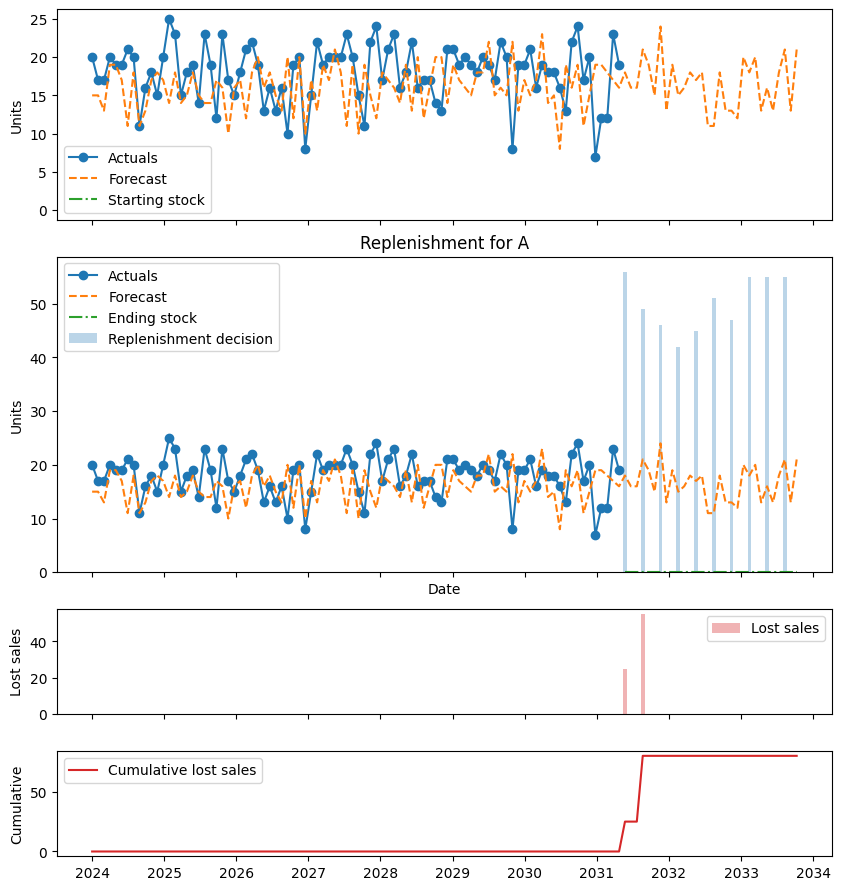

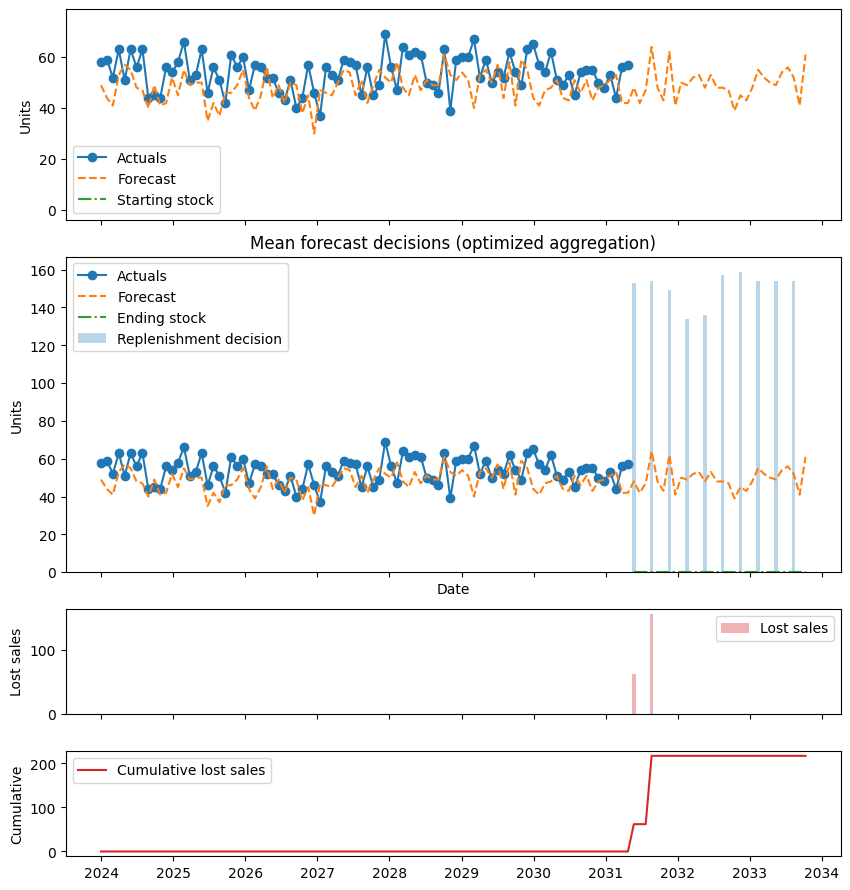

In [9]:
example_id = df["unique_id"].iloc[0]
plot_replenishment_decisions(df, agg_mean_decision_df, unique_id=example_id)
plot_replenishment_decisions(
    df,
    agg_mean_decision_df,
    aggregate=True,
    title="Mean forecast decisions (optimized aggregation)",
)


In [10]:
agg_mean_decision_df


,unique_id,ds,quantity,demand,forecast_quantity,incoming_stock,starting_stock,ending_stock,starting_on_hand,ending_on_hand,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,percentile_target
0,A,2031-05-24,56,50,50,0,25,0,25,0,0,56,25,25,0.95,3,None
1,A,2031-08-22,49,55,55,0,0,0,0,0,0,105,80,55,0.95,3,None
2,A,2031-11-20,46,56,56,56,56,0,0,0,0,95,80,0,0.95,3,None
3,A,2032-02-18,42,49,49,49,49,0,0,0,0,88,80,0,0.95,3,None
4,A,2032-05-18,45,46,46,46,46,0,0,0,0,87,80,0,0.95,3,None
5,A,2032-08-16,51,42,42,42,42,0,0,0,0,96,80,0,0.95,3,None
6,A,2032-11-14,47,45,45,45,45,0,0,0,0,98,80,0,0.95,3,None
7,A,2033-02-12,55,51,51,51,51,0,0,0,0,102,80,0,0.95,3,None
8,A,2033-05-13,55,47,47,47,47,0,0,0,0,110,80,0,0.95,3,None
9,A,2033-08-11,55,55,55,55,55,0,0,0,0,110,80,0,0.95,3,None
